# Dataset Used:
[wikipedia-paragraphs](https://huggingface.co/datasets/agentlans/wikipedia-paragraphs) from Hugging Face


- What is the right way of clustering?
- Is it based on the closeness or cosine similarity? What happens when we have more similar words, how can we cluster them?
- Can we have a new clustering technique, based on the next token?


In [1]:
pip install datasets

In [2]:
from datasets import load_dataset

ds = load_dataset("agentlans/wikipedia-paragraphs")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import numpy as np
import torch
from tqdm import tqdm

In [4]:
def load_paragraphs_hf():
    ds = load_dataset("agentlans/wikipedia-paragraphs", split="train")
    return ds["text"]

paragraphs = load_paragraphs_hf()
print(f"Loaded {len(paragraphs):,} paragraphs")

Loaded 21,811 paragraphs


In [5]:
print(paragraphs[0])

Perhaps the first public statement on the matter to be both serious and strong came from Catherine II (Catherine the Great), whose liberal views were consistent with her acceptance of the Enlightenment. In her Nakaz of 1767, the empress expressed disdain for the death penalty, considering it to be improper, adding: "In the usual state of the society, the death penalty is neither useful nor needed." However, an explicit exception was still allowed for the case of someone who, even while convicted and incarcerated, "still has the means and the might to ignite public unrest". This specific exception applied to mutineers of Pugachev's Rebellion in 1775. Consistent with Catherine's stance, the next several decades marked a shift in public perception against the death penalty. In 1824, the very existence of such a punishment was among the reasons for the legislature's refusal to approve a new version of the Penal Code. Just one year later, the Decembrist revolt failed, and a court sentenced 

# KMeans Clustering

# Model: NovaSearch/stella_en_400M_v5

In [ ]:
!pip show torchvision

!pip show torch


In [ ]:
pip install xformers==0.0.28.post1


In [ ]:
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
  --index-url https://download.pytorch.org/whl/cu121

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
embeddings = model.encode(paragraphs)

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [7]:
pip install scikit-learn kneed

In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from kneed import KneeLocator

def find_knee_point_kmeans(embeddings, k_samples=50, k_min=700, k_max=1400):
    distortions = []

    random.seed(42)
    K = sorted(random.sample(range(k_min, k_max + 1), k_samples))

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    knee = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    plt.figure(figsize=(6, 4))
    plt.plot(K, distortions, 'bo-', label='Inertia')
    if optimal_k:
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method for Random k Samples')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_k


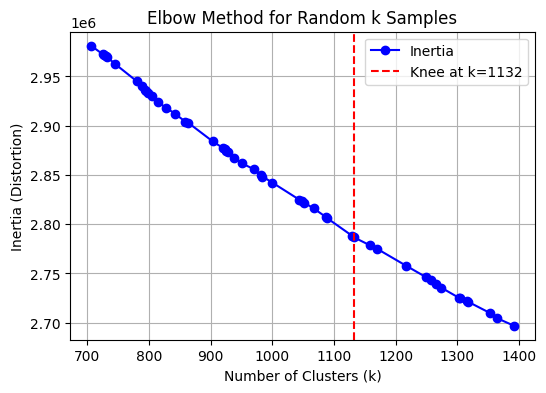

In [43]:
optimal_k = find_knee_point_kmeans(embeddings)

In [10]:
kmeans = KMeans(n_clusters=1132, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

print(f"KMeans completed with k = {1132}")

KMeans completed with k = 1132


In [11]:
#find the number of points in each clusters. store it into a vector.
from collections import Counter

cluster_counts = Counter(labels)

counts = np.array(list(cluster_counts.values()))


sorted_counts_desc = np.sort(counts)[::-1]

print("sentence counts sorted: ", sorted_counts_desc)

sentence counts sorted:  [69 69 67 ...  3  3  1]


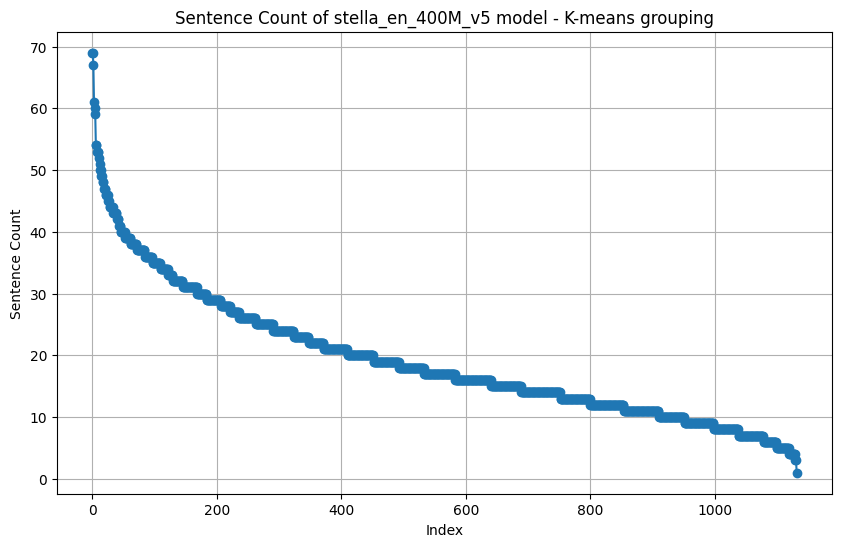

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Plot sentence count distribution
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_counts_desc)), sorted_counts_desc, marker='o')
plt.title("Sentence Count of stella_en_400M_v5 model - K-means grouping")
plt.xlabel('Index')
plt.ylabel('Sentence Count')
plt.grid(True)
plt.show()


Regression Results:
   - Slope: -0.4924
   - Intercept: 2.5122
   - R-squared: 0.7669
   - P-value: 0.0000e+00


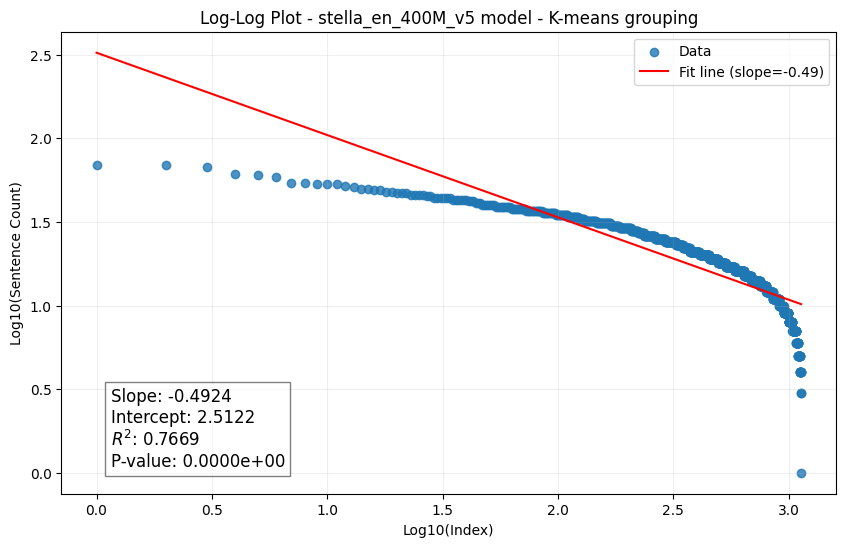

In [13]:

# Linear regression function
def linear_regression(counts):
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

# Apply regression
x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_counts_desc)

# Plot regression line on log-log data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.8, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
plt.title("Log-Log Plot - stella_en_400M_v5 model - K-means grouping")
plt.xlabel('Log10(Index)')
plt.ylabel('Log10(Sentence Count)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Annotate stats
text_x = min(x) + (max(x) - min(x)) * 0.02
text_y = min(y) + (max(y) - min(y)) * 0.02
plt.text(text_x, text_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Print to console
print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")

plt.show()